# Cause-Specific Cox Proportional Hazards Models with Time-Varying Covariates

This notebook fits **cause-specific Cox models** for prepayment and default using the loan-month panel data with time-varying covariates.

## Methodology (Blumenstock et al. 2022)

### Data Structure
- **Interval format**: Each loan contributes multiple rows (one per month)
- **Time-varying covariates**: Behavioral and macroeconomic variables updated each month
- **Fold-based cross-validation**: 11 folds for robust evaluation

### Covariates
- **Static**: FICO, LTV, DTI, interest rate, original UPB
- **Behavioral**: Balance repaid %, 12-month rolling delinquency counts
- **Macro**: HPI changes, mortgage rate spread, Treasury rate changes, unemployment

### Models
1. Cause-specific Cox for **prepayment** (default treated as censored)
2. Cause-specific Cox for **default** (prepayment treated as censored)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Survival analysis
from lifelines import CoxTimeVaryingFitter  # Correct fitter for time-varying covariates
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
%matplotlib inline

# Time horizons for evaluation (months)
TIME_HORIZONS = [24, 48, 72]

print("Imports complete.")
print(f"Time horizons for C-index evaluation: {TIME_HORIZONS} months")

In [48]:
# === CONFIGURATION ===
DATA_DIR = Path('../data/processed')
FIGURES_DIR = Path('../reports/figures')
MODELS_DIR = Path('../models')

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Cross-validation folds (Blumenstock: fold 10 for hyperparameter tuning)
TRAIN_FOLDS = list(range(10))  # Folds 0-9 for training/validation
TUNE_FOLD = 10                  # Fold 10 for hyperparameter tuning

print(f"Training folds: {TRAIN_FOLDS}")
print(f"Tuning fold: {TUNE_FOLD}")

Training folds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Tuning fold: 10


---

## Load Loan-Month Panel Data

In [49]:
# Load the loan-month panel data
print("Loading loan-month panel data...")
panel_df = pd.read_parquet(DATA_DIR / 'loan_month_panel.parquet')

print(f"Loaded {len(panel_df):,} loan-months")
print(f"Unique loans: {panel_df['loan_sequence_number'].nunique():,}")
print(f"Folds: {sorted(panel_df['fold'].unique())}")
print(f"Vintages: {panel_df['vintage_year'].min()} - {panel_df['vintage_year'].max()}")

print("\nEvent distribution:")
event_names = {0: 'Censored', 1: 'Prepay', 2: 'Default'}
terminal_events = panel_df[panel_df['event'] == 1].groupby('event_code').size()
for code, count in terminal_events.items():
    print(f"  {event_names.get(code, 'Other')} (k={code}): {count:,}")

Loading loan-month panel data...
Loaded 5,462,536 loan-months
Unique loans: 109,111
Folds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Vintages: 2010 - 2025

Event distribution:
  Prepay (k=1): 61,394
  Default (k=2): 1,078


In [50]:
# Examine data structure
print("=== Panel Data Structure ===")
print(f"\nColumns: {list(panel_df.columns)}")

print("\n=== Example: Single Loan History ===")
example_loan = panel_df['loan_sequence_number'].iloc[0]
example_df = panel_df[panel_df['loan_sequence_number'] == example_loan].head(10)
print(example_df[['loan_sequence_number', 'start', 'stop', 'event', 'event_code', 
                  'loan_age', 'bal_repaid', 't_del_30d_12m']].to_string(index=False))

print("\n=== Interval Format ===")
print("Each row represents interval (start, stop] where:")
print("  - start: Beginning of interval (loan_age - 1)")
print("  - stop: End of interval (loan_age)")
print("  - event: 1 if terminal event occurs at stop, 0 otherwise")

=== Panel Data Structure ===

Columns: ['loan_sequence_number', 'fold', 'vintage_year', 'property_state', 'loan_age', 'start', 'stop', 'year_month', 'event', 'event_code', 'int_rate', 'orig_upb', 'fico_score', 'dti_r', 'ltv_r', 'bal_repaid', 't_act_12m', 't_del_30d_12m', 't_del_60d_12m', 'hpi_st_d_t_o', 'ppi_c_FRMA', 'TB10Y_d_t_o', 'FRMA30Y_d_t_o', 'ppi_o_FRMA', 'hpi_st_log12m', 'hpi_r_st_us', 'st_unemp_r12m', 'st_unemp_r3m', 'TB10Y_r12m', 'T10Y3MM', 'T10Y3MM_r12m']

=== Example: Single Loan History ===
loan_sequence_number  start  stop  event  event_code  loan_age  bal_repaid  t_del_30d_12m
        F10Q10000194      0     1      0           0         1         0.0            0.0
        F10Q10000194      1     2      0           0         2         0.0            0.0
        F10Q10000194      2     3      0           0         3         0.0            0.0
        F10Q10000194      3     4      0           0         4         0.0            0.0
        F10Q10000194      4     5      0 

In [51]:
# Verify interval format validity
print("=== Verifying Interval Format ===")

# Check start < stop
invalid_intervals = (panel_df['start'] >= panel_df['stop']).sum()
print(f"Invalid intervals (start >= stop): {invalid_intervals:,}")

# Check start values
print(f"\nStart value distribution:")
print(f"  Min: {panel_df['start'].min()}")
print(f"  Max: {panel_df['start'].max()}")
print(f"  Negative starts: {(panel_df['start'] < 0).sum():,}")

# Check stop values
print(f"\nStop value distribution:")
print(f"  Min: {panel_df['stop'].min()}")
print(f"  Max: {panel_df['stop'].max()}")

# For lifelines, start must be >= 0
# Since loan_age starts at 1, start = loan_age - 1 starts at 0
if panel_df['start'].min() < 0:
    print("\n⚠ Warning: Negative start values found. Adjusting...")
    # This shouldn't happen with loan_age starting at 1
else:
    print("\n✓ All start values are non-negative")

=== Verifying Interval Format ===
Invalid intervals (start >= stop): 0

Start value distribution:
  Min: 0
  Max: 183
  Negative starts: 0

Stop value distribution:
  Min: 1
  Max: 184

✓ All start values are non-negative


---

## Define Features

In [52]:
# Define feature groups (Blumenstock et al. 2022, Table 2)

# Static covariates (fixed at origination) - 5 variables
STATIC_FEATURES = [
    'int_rate',      # Initial interest rate
    'orig_upb',      # Original unpaid balance
    'fico_score',    # Initial FICO score
    'dti_r',         # Initial debt-to-income ratio
    'ltv_r',         # Initial loan-to-value ratio
]

# Behavioral covariates (time-varying) - 4 variables
BEHAVIORAL_FEATURES = [
    'bal_repaid',      # Current repaid balance in percent
    't_act_12m',       # No. of times not being delinquent in last 12 months
    't_del_30d_12m',   # No. of times being 30 days delinquent in last 12 months
    't_del_60d_12m',   # No. of times being 60 days delinquent in last 12 months
]

# Macro covariates (time-varying) - 12 variables from Blumenstock Table 2
MACRO_FEATURES = [
    # Origination-relative differences
    'hpi_st_d_t_o',    # HPI difference between origination and today (state)
    'ppi_c_FRMA',      # Current prepayment incentive (loan rate - current mortgage rate)
    'TB10Y_d_t_o',     # Treasury rate difference (today - origination)
    'FRMA30Y_d_t_o',   # 30Y FRM difference (today - origination)
    'ppi_o_FRMA',      # Prepayment incentive at origination (loan rate - orig mortgage rate)
    
    # State-level variables
    'hpi_st_log12m',   # HPI 12-month log return (state)
    'hpi_r_st_us',     # Ratio of state HPI to national HPI
    'st_unemp_r12m',   # Unemployment 12-month log return (state)
    'st_unemp_r3m',    # Unemployment 3-month log return (state)
    
    # National macro variables
    'TB10Y_r12m',      # Treasury rate 12-month return
    'T10Y3MM',         # Yield spread (10Y - 3M)
    'T10Y3MM_r12m',    # Yield spread 12-month return
]

# All features (9 loan-level + 12 macro = 21 total, matching Blumenstock Dataset 2)
ALL_FEATURES = STATIC_FEATURES + BEHAVIORAL_FEATURES + MACRO_FEATURES

# Filter to available features
available_features = [f for f in ALL_FEATURES if f in panel_df.columns]
missing_features = [f for f in ALL_FEATURES if f not in panel_df.columns]

print("=== Feature Groups (Blumenstock et al. 2022) ===")
print(f"Static features: {len([f for f in STATIC_FEATURES if f in available_features])}/5")
print(f"Behavioral features: {len([f for f in BEHAVIORAL_FEATURES if f in available_features])}/4")
print(f"Macro features: {len([f for f in MACRO_FEATURES if f in available_features])}/12")
print(f"\nTotal available: {len(available_features)}/21")
if missing_features:
    print(f"\nMissing features ({len(missing_features)}):")
    for f in missing_features:
        print(f"  - {f}")

=== Feature Groups (Blumenstock et al. 2022) ===
Static features: 5/5
Behavioral features: 4/4
Macro features: 12/12

Total available: 21/21


In [53]:
# Prepare modeling data
print("=== Preparing Model Data ===")

# Required columns for interval-censored Cox regression
required_cols = ['start', 'stop', 'event', 'event_code', 'fold', 'loan_sequence_number']
model_cols = required_cols + available_features

# Filter to complete cases
df_model = panel_df[model_cols].copy()
n_before = len(df_model)
df_model = df_model.dropna(subset=available_features)
n_after = len(df_model)

print(f"Rows before dropna: {n_before:,}")
print(f"Rows after dropna: {n_after:,}")
print(f"Dropped: {n_before - n_after:,} ({(n_before - n_after) / n_before * 100:.1f}%)")

print(f"\nUnique loans: {df_model['loan_sequence_number'].nunique():,}")

# Log transform UPB for better coefficient interpretation
if 'orig_upb' in df_model.columns:
    df_model['log_upb'] = np.log(df_model['orig_upb'])
    # Replace orig_upb with log_upb in feature list
    available_features = [f if f != 'orig_upb' else 'log_upb' for f in available_features]
    print("\n✓ Created log_upb (log of original UPB)")

=== Preparing Model Data ===
Rows before dropna: 5,462,536
Rows after dropna: 5,458,864
Dropped: 3,672 (0.1%)

Unique loans: 109,067

✓ Created log_upb (log of original UPB)


In [54]:
# Check feature coverage
print("=== Feature Coverage ===")
for feature in available_features:
    coverage = df_model[feature].notna().mean()
    print(f"  {feature}: {coverage:.1%}")

=== Feature Coverage ===
  int_rate: 100.0%
  log_upb: 100.0%
  fico_score: 100.0%
  dti_r: 100.0%
  ltv_r: 100.0%
  bal_repaid: 100.0%
  t_act_12m: 100.0%
  t_del_30d_12m: 100.0%
  t_del_60d_12m: 100.0%
  hpi_st_d_t_o: 100.0%
  ppi_c_FRMA: 100.0%
  TB10Y_d_t_o: 100.0%
  FRMA30Y_d_t_o: 100.0%
  ppi_o_FRMA: 100.0%
  hpi_st_log12m: 100.0%
  hpi_r_st_us: 100.0%
  st_unemp_r12m: 100.0%
  st_unemp_r3m: 100.0%
  TB10Y_r12m: 100.0%
  T10Y3MM: 100.0%
  T10Y3MM_r12m: 100.0%


---

## Split Data by Folds

In [55]:
# Split by folds (Blumenstock methodology)
print("=== Splitting Data by Folds ===")

# Training set: folds 0-9
train_df = df_model[df_model['fold'].isin(TRAIN_FOLDS)].copy()

# Tuning set: fold 10
tune_df = df_model[df_model['fold'] == TUNE_FOLD].copy()

print(f"Training set (folds 0-9):")
print(f"  Loan-months: {len(train_df):,}")
print(f"  Unique loans: {train_df['loan_sequence_number'].nunique():,}")

print(f"\nTuning set (fold 10):")
print(f"  Loan-months: {len(tune_df):,}")
print(f"  Unique loans: {tune_df['loan_sequence_number'].nunique():,}")

# Event distribution in training set
print("\nTraining set event distribution:")
train_events = train_df[train_df['event'] == 1].groupby('event_code').size()
for code, count in train_events.items():
    print(f"  {event_names.get(code, 'Other')}: {count:,}")

=== Splitting Data by Folds ===
Training set (folds 0-9):
  Loan-months: 4,963,775
  Unique loans: 99,156

Tuning set (fold 10):
  Loan-months: 495,089
  Unique loans: 9,911

Training set event distribution:
  Prepay: 55,776
  Default: 977


---

## Cause-Specific Cox Model for Prepayment

Fit Cox model with time-varying covariates where:
- **Event** = prepayment (event_code = 1)
- **Censored** = default, actual censoring, and ongoing observations

In [56]:
# Prepare data for prepayment model (cause-specific)
print("=== Preparing Prepayment Model Data ===")

# Create prepayment-specific event indicator
# Prepay = 1, everything else (default, censored) = 0
train_prepay = train_df.copy()
train_prepay['event_prepay'] = ((train_prepay['event'] == 1) & 
                                 (train_prepay['event_code'] == 1)).astype(int)

tune_prepay = tune_df.copy()
tune_prepay['event_prepay'] = ((tune_prepay['event'] == 1) & 
                                (tune_prepay['event_code'] == 1)).astype(int)

print(f"Training prepayments: {train_prepay['event_prepay'].sum():,}")
print(f"Tuning prepayments: {tune_prepay['event_prepay'].sum():,}")

=== Preparing Prepayment Model Data ===
Training prepayments: 55,776
Tuning prepayments: 5,607


In [57]:
# Fit cause-specific Cox model for prepayment with time-varying covariates
print("=== Fitting Cause-Specific Cox Model: PREPAYMENT ===")

# Columns for CoxTimeVaryingFitter
# Requires: id_col, start, stop, event, and covariates
cox_cols = ['loan_sequence_number', 'start', 'stop', 'event_prepay'] + available_features

# Fit model with penalization for stability
ctv_prepay = CoxTimeVaryingFitter(penalizer=0.01)
ctv_prepay.fit(
    train_prepay[cox_cols],
    id_col='loan_sequence_number',
    start_col='start',
    stop_col='stop',
    event_col='event_prepay',
    show_progress=True
)

print("\n" + "=" * 60)
print("PREPAYMENT MODEL RESULTS")
print("=" * 60)
ctv_prepay.print_summary()

=== Fitting Cause-Specific Cox Model: PREPAYMENT ===
Iteration 1: norm_delta = 3.09e+00, step_size = 0.9500, log_lik = -593413.65723, newton_decrement = 4.06e+05, seconds_since_start = 7.2
Iteration 2: norm_delta = 2.63e+00, step_size = 0.9500, log_lik = -559891.27374, newton_decrement = 2.14e+05, seconds_since_start = 13.5
Iteration 3: norm_delta = 1.40e+00, step_size = 0.9500, log_lik = -488165.01310, newton_decrement = 1.51e+05, seconds_since_start = 20.1
Iteration 4: norm_delta = 7.96e-01, step_size = 1.0000, log_lik = -414127.95717, newton_decrement = 2.98e+04, seconds_since_start = 26.9
Iteration 5: norm_delta = 2.47e-01, step_size = 1.0000, log_lik = -400440.71617, newton_decrement = 8.35e+03, seconds_since_start = 33.9
Iteration 6: norm_delta = 3.18e-02, step_size = 1.0000, log_lik = -391609.92795, newton_decrement = 1.02e+02, seconds_since_start = 40.8
Iteration 7: norm_delta = 7.62e-04, step_size = 1.0000, log_lik = -391506.47218, newton_decrement = 5.77e-02, seconds_since_st

<lifelines.CoxTimeVaryingFitter: fitted with 4963775 periods, 99156 subjects, 55776 events>
         event col = 'event_prepay'
         penalizer = 0.01
number of subjects = 99156
 number of periods = 4963775
  number of events = 55776
partial log-likelihood = -391506.41
  time fit was run = 2026-01-24 10:32:17 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
int_rate       0.03      1.03      0.00            0.02            0.04                1.02                1.04
log_upb        0.13      1.14      0.01            0.12            0.14                1.13                1.15
fico_score    -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
dti_r         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
ltv_r          0.00      1.00      0.00            0.00            0.00                1.00                1.00
bal_repaid     0.07      1.07      0.00            0.07            0.07                1.07                1.07
t_act_12m      0.00      1.00      0.00           -0.00            0.01                1.00                1.01
t_del_30d_12m  0.01      1.01      0.01           -0.01            0.02                0.99                1.02
t_del_60d_12m -0.02      0.98      0.02           -0.07            0.02                0.93                1.02
hpi_st_d_t_o  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ppi_c_FRMA     0.06      1.07      0.00            0.06            0.07                1.06                1.07
TB10Y_d_t_o   -0.05      0.95      0.00           -0.06           -0.05                0.94                0.95
FRMA30Y_d_t_o -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
ppi_o_FRMA     0.19      1.21      0.01            0.18            0.20                1.19                1.22
hpi_st_log12m  0.47      1.60      0.07            0.33            0.61                1.39                1.84
hpi_r_st_us    0.05      1.06      0.01            0.03            0.07                1.03                1.08
st_unemp_r12m  0.07      1.08      0.01            0.06            0.09                1.06                1.09
st_unemp_r3m  -0.04      0.96      0.01           -0.07           -0.01                0.94                0.99
TB10Y_r12m    -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
T10Y3MM        0.03      1.03      0.00            0.02            0.04                1.02                1.04
T10Y3MM_r12m   0.00      1.00      0.00           -0.00            0.00                1.00                1.00

               cmp to      z      p  -log2(p)
covariate                                    
int_rate         0.00   8.49 <0.005     55.40
log_upb          0.00  24.12 <0.005    424.74
fico_score       0.00  -6.09 <0.005     29.75
dti_r            0.00  -5.58 <0.005     25.28
ltv_r            0.00  25.73 <0.005    482.62
bal_repaid       0.00 586.62 <0.005       inf
t_act_12m        0.00   1.88   0.06      4.06
t_del_30d_12m    0.00   0.71   0.48      1.06
t_del_60d_12m    0.00  -1.02   0.31      1.69
hpi_st_d_t_o     0.00  -1.46   0.14      2.79
ppi_c_FRMA       0.00  24.74 <0.005    446.35
TB10Y_d_t_o      0.00 -17.28 <0.005    219.77
FRMA30Y_d_t_o    0.00 -15.34 <0.005    174.00
ppi_o_FRMA       0.00  32.67 <0.005    775.29
hpi_st_log12m    0.00   6.68 <0.005     35.32
hpi_r_st_us      0.00   5.23 <0.005     22.46
st_unemp_r12m    0.00   8.24 <0.005     52.34
st_unemp_r3m     0.00  -3.08 <0.005      8.91
TB10Y_r12m       0.00  -0.95   0.34      1.54
T10Y3MM          0.00   9.81 <0.005     73.03
T10Y3MM_r12m     0.00   0.05   0.96      0.06
---
Partial AIC = 783054.83
log-likelihood

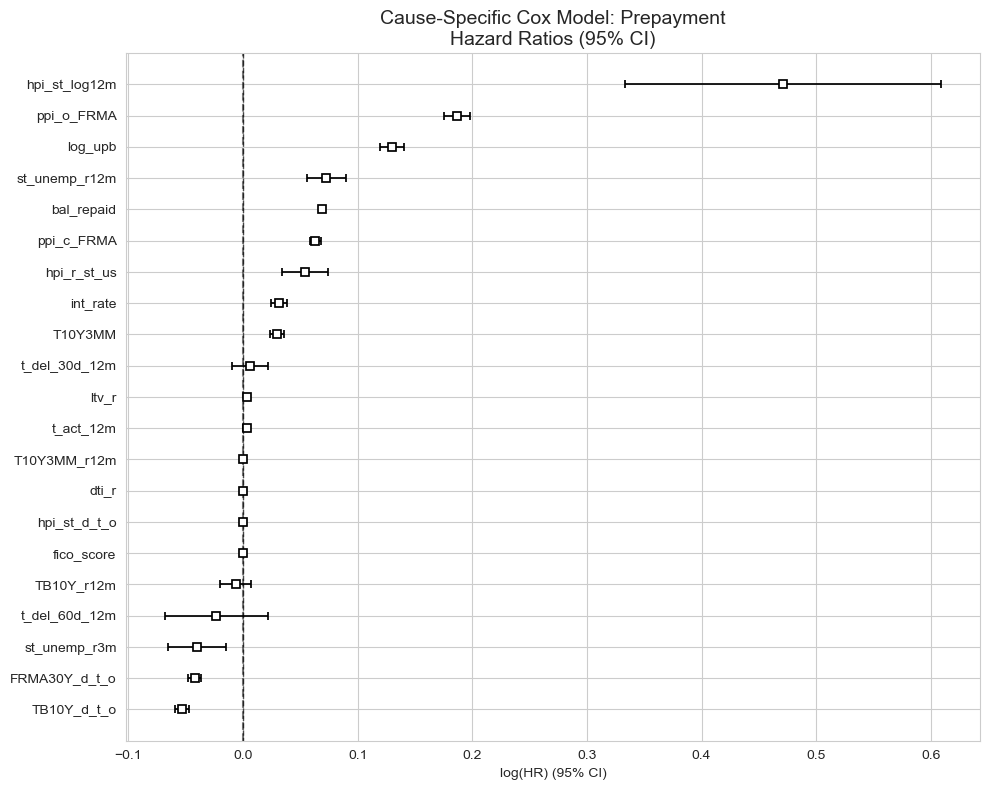

In [58]:
# Plot hazard ratios for prepayment model
fig, ax = plt.subplots(figsize=(10, 8))
ctv_prepay.plot(ax=ax)
ax.set_title('Cause-Specific Cox Model: Prepayment\nHazard Ratios (95% CI)', fontsize=14)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cox_prepay_hazard_ratios_tv.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate prepayment model on tuning set with time-dependent C-index
print("=== Prepayment Model Evaluation (Tuning Set) ===")

# Get terminal observations only for C-index calculation
# (each loan should have exactly one terminal observation)
tune_terminal = tune_df.groupby('loan_sequence_number').last().reset_index()
tune_terminal['event_prepay'] = (tune_terminal['event_code'] == 1).astype(int)

# Also get training terminal observations for IPCW estimation
train_terminal = train_df.groupby('loan_sequence_number').last().reset_index()
train_terminal['event_prepay'] = (train_terminal['event_code'] == 1).astype(int)

# Ensure log_upb exists in both datasets
for df in [tune_terminal, train_terminal]:
    if 'log_upb' not in df.columns and 'orig_upb' in df.columns:
        df['log_upb'] = np.log(df['orig_upb'])

# Compute risk scores using model coefficients
model_features = ctv_prepay.params_.index.tolist()
X_tune = tune_terminal[model_features].astype(float).values
coefs = ctv_prepay.params_.values.astype(float)
risk_prepay = np.exp(X_tune @ coefs)

# Create structured arrays for sksurv (required for concordance_index_ipcw)
def make_survival_array(event, time):
    """Create structured array for scikit-survival."""
    return np.array([(bool(e), t) for e, t in zip(event, time)],
                    dtype=[('event', bool), ('time', float)])

surv_train = make_survival_array(train_terminal['event_prepay'], train_terminal['stop'])
surv_tune = make_survival_array(tune_terminal['event_prepay'], tune_terminal['stop'])

# Calculate time-dependent C-index at different horizons
print(f"\nTime-Dependent C-index (IPCW) for PREPAYMENT:")
print("-" * 50)

cindex_prepay_results = {}
for tau in TIME_HORIZONS:
    try:
        # Filter to observations where we can evaluate at this horizon
        # (i.e., event time > tau OR event occurred before tau)
        mask = tune_terminal['stop'] <= tau
        if mask.sum() < 10:
            print(f"  τ = {tau:3d} months: Insufficient events (n={mask.sum()})")
            continue
            
        c_tau = concordance_index_ipcw(
            surv_train, 
            surv_tune,
            risk_prepay.flatten(),
            tau=tau
        )
        cindex_prepay_results[tau] = c_tau[0]
        print(f"  τ = {tau:3d} months: C-index = {c_tau[0]:.4f}")
    except Exception as e:
        print(f"  τ = {tau:3d} months: Error - {str(e)[:50]}")

# Also calculate overall C-index (Harrell's)
c_index_prepay = concordance_index_censored(
    tune_terminal['event_prepay'].astype(bool),
    tune_terminal['stop'],
    risk_prepay.flatten()
)
print(f"\nOverall C-index (Harrell): {c_index_prepay[0]:.4f}")
print(f"  Concordant: {c_index_prepay[1]:,} | Discordant: {c_index_prepay[2]:,} | Tied: {c_index_prepay[3]:,}")

---

## Cause-Specific Cox Model for Default

Fit Cox model with time-varying covariates where:
- **Event** = default (event_code = 2)
- **Censored** = prepayment, actual censoring, and ongoing observations

In [ ]:
# Prepare data for default model (cause-specific)
print("=== Preparing Default Model Data ===")

# Create default-specific event indicator
# Default = 1, everything else (prepay, censored) = 0
train_default = train_df.copy()
train_default['event_default'] = ((train_default['event'] == 1) & 
                                   (train_default['event_code'] == 2)).astype(int)

tune_default = tune_df.copy()
tune_default['event_default'] = ((tune_default['event'] == 1) & 
                                  (tune_default['event_code'] == 2)).astype(int)

print(f"Training defaults: {train_default['event_default'].sum():,}")
print(f"Tuning defaults: {tune_default['event_default'].sum():,}")

In [ ]:
# Fit cause-specific Cox model for default with time-varying covariates
print("=== Fitting Cause-Specific Cox Model: DEFAULT ===")

# Columns for CoxTimeVaryingFitter
cox_cols = ['loan_sequence_number', 'start', 'stop', 'event_default'] + available_features

# Fit model with penalization for stability
ctv_default = CoxTimeVaryingFitter(penalizer=0.01)
ctv_default.fit(
    train_default[cox_cols],
    id_col='loan_sequence_number',
    start_col='start',
    stop_col='stop',
    event_col='event_default',
    show_progress=True
)

print("\n" + "=" * 60)
print("DEFAULT MODEL RESULTS")
print("=" * 60)
ctv_default.print_summary()

In [ ]:
# Plot hazard ratios for default model
fig, ax = plt.subplots(figsize=(10, 8))
ctv_default.plot(ax=ax)
ax.set_title('Cause-Specific Cox Model: Default\nHazard Ratios (95% CI)', fontsize=14)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cox_default_hazard_ratios_tv.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate default model on tuning set with time-dependent C-index
print("=== Default Model Evaluation (Tuning Set) ===")

# Update event indicators for default
tune_terminal['event_default'] = (tune_terminal['event_code'] == 2).astype(int)
train_terminal['event_default'] = (train_terminal['event_code'] == 2).astype(int)

# Compute risk scores using model coefficients
model_features = ctv_default.params_.index.tolist()
X_tune = tune_terminal[model_features].astype(float).values
coefs = ctv_default.params_.values.astype(float)
risk_default = np.exp(X_tune @ coefs)

# Create structured arrays for default
surv_train_def = make_survival_array(train_terminal['event_default'], train_terminal['stop'])
surv_tune_def = make_survival_array(tune_terminal['event_default'], tune_terminal['stop'])

# Calculate time-dependent C-index at different horizons
print(f"\nTime-Dependent C-index (IPCW) for DEFAULT:")
print("-" * 50)

cindex_default_results = {}
for tau in TIME_HORIZONS:
    try:
        mask = tune_terminal['stop'] <= tau
        if mask.sum() < 10:
            print(f"  τ = {tau:3d} months: Insufficient events (n={mask.sum()})")
            continue
            
        c_tau = concordance_index_ipcw(
            surv_train_def, 
            surv_tune_def,
            risk_default.flatten(),
            tau=tau
        )
        cindex_default_results[tau] = c_tau[0]
        print(f"  τ = {tau:3d} months: C-index = {c_tau[0]:.4f}")
    except Exception as e:
        print(f"  τ = {tau:3d} months: Error - {str(e)[:50]}")

# Also calculate overall C-index (Harrell's)
c_index_default = concordance_index_censored(
    tune_terminal['event_default'].astype(bool),
    tune_terminal['stop'],
    risk_default.flatten()
)
print(f"\nOverall C-index (Harrell): {c_index_default[0]:.4f}")
print(f"  Concordant: {c_index_default[1]:,} | Discordant: {c_index_default[2]:,} | Tied: {c_index_default[3]:,}")

---

## Compare Coefficients: Prepayment vs Default

In [ ]:
# Extract and compare coefficients
prepay_coefs = ctv_prepay.summary[['coef', 'exp(coef)', 'p']].copy()
prepay_coefs.columns = ['coef_prepay', 'hr_prepay', 'p_prepay']

default_coefs = ctv_default.summary[['coef', 'exp(coef)', 'p']].copy()
default_coefs.columns = ['coef_default', 'hr_default', 'p_default']

# Combine
comparison = prepay_coefs.join(default_coefs)
comparison['coef_diff'] = comparison['coef_prepay'] - comparison['coef_default']
comparison['effect_direction'] = np.where(
    comparison['coef_prepay'] * comparison['coef_default'] > 0,
    'Same', 'Opposite'
)

print("=== Coefficient Comparison: Prepayment vs Default ===")
print(comparison.round(4).to_string())

In [ ]:
# Plot coefficient comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Bar chart of coefficients
ax = axes[0]
x = np.arange(len(available_features))
width = 0.35

bars1 = ax.barh(x - width/2, comparison['coef_prepay'], width, 
                label='Prepayment', color='steelblue', alpha=0.7)
bars2 = ax.barh(x + width/2, comparison['coef_default'], width, 
                label='Default', color='indianred', alpha=0.7)

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Feature')
ax.set_xlabel('Coefficient')
ax.set_title('Cause-Specific Cox Coefficients', fontsize=12)
ax.set_yticks(x)
ax.set_yticklabels(available_features)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Right: Hazard ratios
ax = axes[1]
ax.barh(x - width/2, comparison['hr_prepay'], width, 
        label='Prepayment', color='steelblue', alpha=0.7)
ax.barh(x + width/2, comparison['hr_default'], width, 
        label='Default', color='indianred', alpha=0.7)

ax.axvline(x=1, color='black', linestyle='--', linewidth=0.5)
ax.set_ylabel('Feature')
ax.set_xlabel('Hazard Ratio')
ax.set_title('Cause-Specific Hazard Ratios', fontsize=12)
ax.set_yticks(x)
ax.set_yticklabels(available_features)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cox_coefficient_comparison_tv.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Interpretation of key coefficients
print("=== Key Coefficient Interpretations ===")

def interpret_coef(name, hr_prepay, hr_default, p_prepay, p_default):
    print(f"\n{name}:")
    
    # Prepayment effect
    if p_prepay < 0.05:
        if hr_prepay > 1:
            print(f"  Prepayment: +1 unit → {(hr_prepay-1)*100:.1f}% higher prepay hazard")
        else:
            print(f"  Prepayment: +1 unit → {(1-hr_prepay)*100:.1f}% lower prepay hazard")
    else:
        print(f"  Prepayment: Not significant (p={p_prepay:.3f})")
    
    # Default effect
    if p_default < 0.05:
        if hr_default > 1:
            print(f"  Default: +1 unit → {(hr_default-1)*100:.1f}% higher default hazard")
        else:
            print(f"  Default: +1 unit → {(1-hr_default)*100:.1f}% lower default hazard")
    else:
        print(f"  Default: Not significant (p={p_default:.3f})")

# Key variables to interpret
key_vars = ['fico_score', 'ltv_r', 'ppi_c_FRMA', 'bal_repaid', 't_del_30d_12m', 'hpi_st_d_t_o']
key_vars = [v for v in key_vars if v in comparison.index]

for var in key_vars:
    interpret_coef(
        var,
        comparison.loc[var, 'hr_prepay'],
        comparison.loc[var, 'hr_default'],
        comparison.loc[var, 'p_prepay'],
        comparison.loc[var, 'p_default']
    )

---

## Model Summary

In [ ]:
print("=" * 70)
print("CAUSE-SPECIFIC COX MODELS WITH TIME-VARYING COVARIATES - SUMMARY")
print("=" * 70)

print(f"\nData:")
print(f"  Training loan-months: {len(train_df):,}")
print(f"  Training unique loans: {train_df['loan_sequence_number'].nunique():,}")
print(f"  Tuning loan-months: {len(tune_df):,}")
print(f"  Tuning unique loans: {tune_df['loan_sequence_number'].nunique():,}")

print(f"\nFeatures: {len(available_features)}")
print(f"  Static: {len([f for f in STATIC_FEATURES if f in available_features or f.replace('orig_upb', 'log_upb') in available_features])}")
print(f"  Behavioral (time-varying): {len([f for f in BEHAVIORAL_FEATURES if f in available_features])}")
print(f"  Macro (time-varying): {len([f for f in MACRO_FEATURES if f in available_features])}")

print(f"\n{'='*70}")
print("MODEL PERFORMANCE (Tuning Set)")
print("="*70)

print(f"\nPREPAYMENT MODEL:")
print(f"  Training events: {train_prepay['event_prepay'].sum():,}")
print(f"  Overall C-index (Harrell): {c_index_prepay[0]:.4f}")
print(f"  Time-Dependent C-index (IPCW):")
for tau, c in cindex_prepay_results.items():
    print(f"    τ = {tau:3d} months: {c:.4f}")

print(f"\nDEFAULT MODEL:")
print(f"  Training events: {train_default['event_default'].sum():,}")
print(f"  Overall C-index (Harrell): {c_index_default[0]:.4f}")
print(f"  Time-Dependent C-index (IPCW):")
for tau, c in cindex_default_results.items():
    print(f"    τ = {tau:3d} months: {c:.4f}")

In [ ]:
# Plot time-dependent C-index comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for plotting
horizons = sorted(set(cindex_prepay_results.keys()) & set(cindex_default_results.keys()))
prepay_cindex = [cindex_prepay_results[h] for h in horizons]
default_cindex = [cindex_default_results[h] for h in horizons]

x = np.arange(len(horizons))
width = 0.35

bars1 = ax.bar(x - width/2, prepay_cindex, width, label='Prepayment', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, default_cindex, width, label='Default', color='indianred', alpha=0.8)

# Add value labels on bars
for bar, val in zip(bars1, prepay_cindex):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, default_cindex):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Add reference line at 0.5
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (0.5)')

ax.set_xlabel('Time Horizon (months)', fontsize=12)
ax.set_ylabel('C-index (IPCW)', fontsize=12)
ax.set_title('Time-Dependent Concordance Index by Event Type', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f'τ = {h}' for h in horizons])
ax.set_ylim(0.4, 1.0)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cox_time_dependent_cindex.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {FIGURES_DIR / 'cox_time_dependent_cindex.png'}")

---

## Save Models

In [ ]:
import pickle

# Save models
with open(MODELS_DIR / 'cox_prepay_tv.pkl', 'wb') as f:
    pickle.dump(ctv_prepay, f)
    
with open(MODELS_DIR / 'cox_default_tv.pkl', 'wb') as f:
    pickle.dump(ctv_default, f)

# Save feature list
with open(MODELS_DIR / 'cox_features.pkl', 'wb') as f:
    pickle.dump(available_features, f)

# Save comparison table
comparison.to_csv(MODELS_DIR / 'cox_coefficient_comparison.csv')

print(f"Models saved to {MODELS_DIR}:")
print(f"  - cox_prepay_tv.pkl (CoxTimeVaryingFitter)")
print(f"  - cox_default_tv.pkl (CoxTimeVaryingFitter)")
print(f"  - cox_features.pkl")
print(f"  - cox_coefficient_comparison.csv")

---

## Next Steps

### Completed
- ✅ Loaded loan-month panel data with time-varying covariates
- ✅ Fit cause-specific Cox model for prepayment
- ✅ Fit cause-specific Cox model for default
- ✅ Evaluated models on tuning set (C-index)
- ✅ Compared coefficient effects between models

### Key Findings
- Time-varying covariates capture dynamic risk factors
- Behavioral variables (delinquency history) strongly predict default
- Prepayment incentive (rate spread) drives prepayment hazard
- HPI changes affect both prepayment and default risks

### Future Work
1. **Cross-validation**: Use folds 0-9 for k-fold cross-validation
2. **Fine-Gray models**: Subdistribution hazard for cumulative incidence
3. **Deep learning**: DeepSurv or DeepHit for non-linear effects
4. **Calibration**: Assess predicted vs actual cumulative incidence